<b><h1 style="text-align:center;">COMM493 - Coding AI for Business</h1></b>
<h5 style="text-align:center;">K-MEANS CLUSTERING FOR GYM MEMBERSHIP CUSTOMERS</h5>
<h5 style="text-align:center;">INSERT NAMES HERE</h5>
<h5 style="text-align:center;">March 31st, 2025</h5>

### Introduction
**Motivation:** TODO

**Data:** <a href="https://www.kaggle.com/datasets/ka66ledata/gym-membership-dataset/data">gym-membership-dataset</a> 

**Goal:** TODO

### 0: Set Up Environment
Load imports and define constants that will be used to prepare data and train model.

In [1]:
# install mxnet
get_ipython().system('pip install mxnet')

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# AWS SageMaker and Boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.image_uris import retrieve
import boto3

# Data Manipulation
import pandas as pd
import numpy as np
np.bool = bool

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Machine Learning
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Additional Libraries
import tarfile
import mxnet as mx

[03/25/25 02:09:52] INFO     Found credentials from IAM Role:                                   ]8;id=673132;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=765946;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 1: SageMaker Setup & Configuration
ADD INFO HERE

In [2]:
# Initialize a SageMaker Session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')
image_uri = retrieve('kmeans', region)
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/mall/kmeans-all'
print("Execution Role ARN:", role)
print("AWS Region:", region)

[03/25/25 02:09:54] INFO     Found credentials from IAM Role:                                   ]8;id=941548;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=841395;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=857983;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=120903;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=330958;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=121838;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=125998;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=960099;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/25/25 02:09:55] INFO     Ignoring unnecessary instance type: None.                            ]8;id=392622;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=232387;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Execution Role ARN: arn:aws:iam::922202922528:role/LabRole
AWS Region: us-east-1


### 2: Helper Functions
ADD INFO HERE

In [3]:
def time_to_minutes(t):
    """Convert time in HH:MM:SS format to minutes."""
    try:
        h, m, s = map(int, t.split(':'))
        return h * 60 + m
    except (ValueError, AttributeError):  # Handle missing or incorrect format
        return np.nan


def remove_outliers_iqr(df, cols, factor=1.5):
    """Remove outliers using the IQR method for selected columns."""
    for col in cols:
        q1 = df[col].quantile(0.10)
        q3 = df[col].quantile(0.90)
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


def plot_cluster_results(data, labels, centroids, title):
    """Visualize clusters in 3D PCA space with silhouette score"""
    # reduce to 3 dimensions
    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(data)
    centroids_pca = pca.transform(centroids)
    
    # init figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot data points
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
                        c=labels, cmap='viridis', s=50, alpha=0.6)
    
    # Plot centroids
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
              c='red', marker='X', s=200, edgecolor='black', linewidth=1.5)
    
    ax.set_title(f'{title}\nSilhouette Score: {silhouette_score(data, labels):.3f}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.colorbar(scatter, ax=ax, label='Cluster')
    plt.tight_layout()
    plt.show()

### 2: Load and Process Data
ADD INFO HERE

In [4]:
# Load data
df = pd.read_csv('gym_membership.csv')

# Feature engineering: calculate stay duration in minutes
df['stay_in_minutes'] = df.apply(
    lambda row: time_to_minutes(row['avg_time_check_out']) - time_to_minutes(row['avg_time_check_in']),
    axis=1
)

# Drop irrelevant columns
cols_to_drop = [
    'id', 'birthday', 'days_per_week', 'name_personal_trainer',
    'avg_time_check_in', 'avg_time_check_out', 'avg_time_in_gym',
    'fav_group_lesson', 'fav_drink', 'drink_abo'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

# Encode categorical features
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['abonoment_type'] = df['abonoment_type'].map({'Premium': 1, 'Standard': 0})

# Convert boolean columns to integers
bool_cols = ['attend_group_lesson', 'personal_training', 'uses_sauna']
df[bool_cols] = df[bool_cols].astype(int)

# Identify numerical columns for scaling and outlier removal
# (Exclude already encoded categorical features and booleans)
num_cols = df.columns.difference(['gender', 'abonoment_type'] + bool_cols)

# Apply RobustScaler to reduce the impact of any remaining outliers
scaler = RobustScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Remove outliers using the IQR method for numerical features
df = remove_outliers_iqr(df, num_cols, factor=1.5)

print("Processed Data Preview:")
print(df.head())

data_np = df.values.astype('float32')

Processed Data Preview:
   gender       Age  abonoment_type  visit_per_week  attend_group_lesson  \
0       1 -0.157895               1             1.0                    1   
1       1  0.894737               0             0.0                    0   
2       0  0.578947               1            -2.0                    1   
3       0  0.736842               1             0.0                    0   
4       0  0.736842               0            -1.0                    1   

   personal_training  uses_sauna  stay_in_minutes  
0                  0           1         0.157895  
1                  1           0        -0.736842  
2                  1           0         0.250000  
3                  1           1        -0.065789  
4                  1           0        -0.710526  


### 3: Create Visualization Function
ADD INFO HERE

In [5]:


# plot_cluster_results(df)

### 4: Perform k-Means Clustering (k=2,3,...,7)
ADD INFO HERE

In [6]:
k_values = range(2, 8)
training_jobs = []
output_path = f's3://{bucket}/output'

for k in k_values:
    kmeans = KMeans(
        sagemaker_session=sagemaker_session,
        role=role,
        instance_count=1,
        instance_type='ml.m5.xlarge',  # More powerful instance for better performance
        k=k,
        output_path=output_path,
        feature_dim=data_np.shape[1],
        extra_hyperparameters={
        'kmeans_init_method': 'kmeans++',
        'epochs': 100,
        'mini_batch_size': 256,
        'extra_center_factor': 5
        }
    )
    kmeans.fit(kmeans.record_set(data_np), wait=False)
    training_jobs.append((k, kmeans.latest_training_job.name))

# Wait for all jobs to complete
for k, job_name in training_jobs:
    boto3.client('sagemaker').get_waiter('training_job_completed_or_stopped').wait(
        TrainingJobName=job_name)

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=478680;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=871599;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=414575;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=120430;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=382761;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=438935;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=348884;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=544567;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-02-09-55-597        ]8;id=192952;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=837332;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 02:09:56] INFO     Same images used for training and inference. Defaulting to image     ]8;id=68603;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=603872;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=913865;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=600829;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=818221;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=785598;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=13096;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=753814;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-02-09-56-095        ]8;id=744784;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=467290;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 02:09:57] INFO     Same images used for training and inference. Defaulting to image     ]8;id=826109;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=873718;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=713758;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=319975;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=11906;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=16038;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=753668;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=373839;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-02-09-57-643        ]8;id=281938;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=564235;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 02:09:58] INFO     Same images used for training and inference. Defaulting to image     ]8;id=28269;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=384926;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=468513;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=293297;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=571532;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=219438;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=976;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=984183;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-02-09-58-287        ]8;id=393531;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=953077;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 02:09:59] INFO     Same images used for training and inference. Defaulting to image     ]8;id=560587;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=51485;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=218047;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=174608;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=907643;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=434584;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=871122;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=497184;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-02-09-59-862        ]8;id=872461;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=574104;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

[03/25/25 02:10:00] INFO     Same images used for training and inference. Defaulting to image     ]8;id=717115;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=267472;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[03/25/25 02:10:01] INFO     Ignoring unnecessary instance type: None.                            ]8;id=174858;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=693053;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=727184;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=926904;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=128234;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=856413;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-03-25-02-10-01-002        ]8;id=316362;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=713465;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

### 5: Select Best K Value With Sum of Squared Error (SSE) & Silhouette Score
ADD INFO HERE

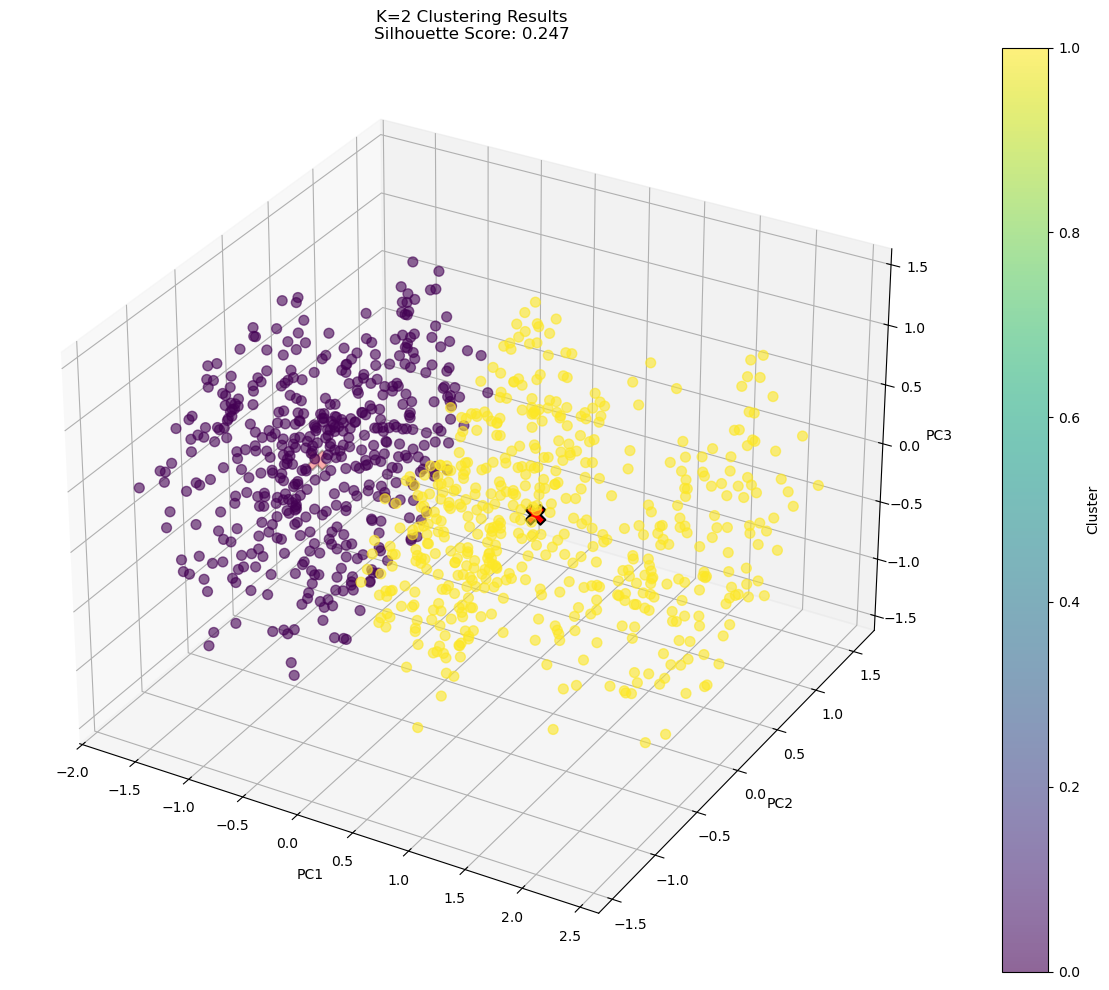

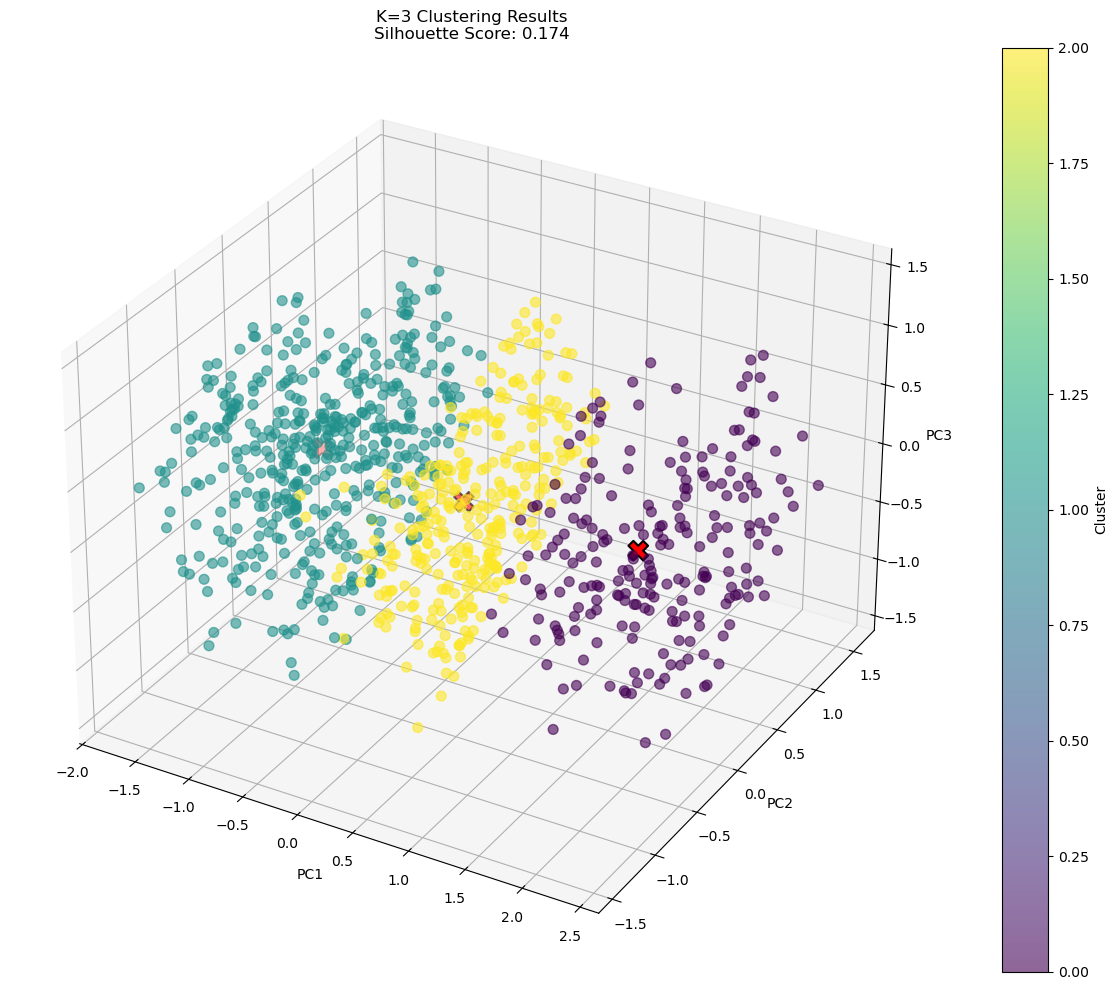

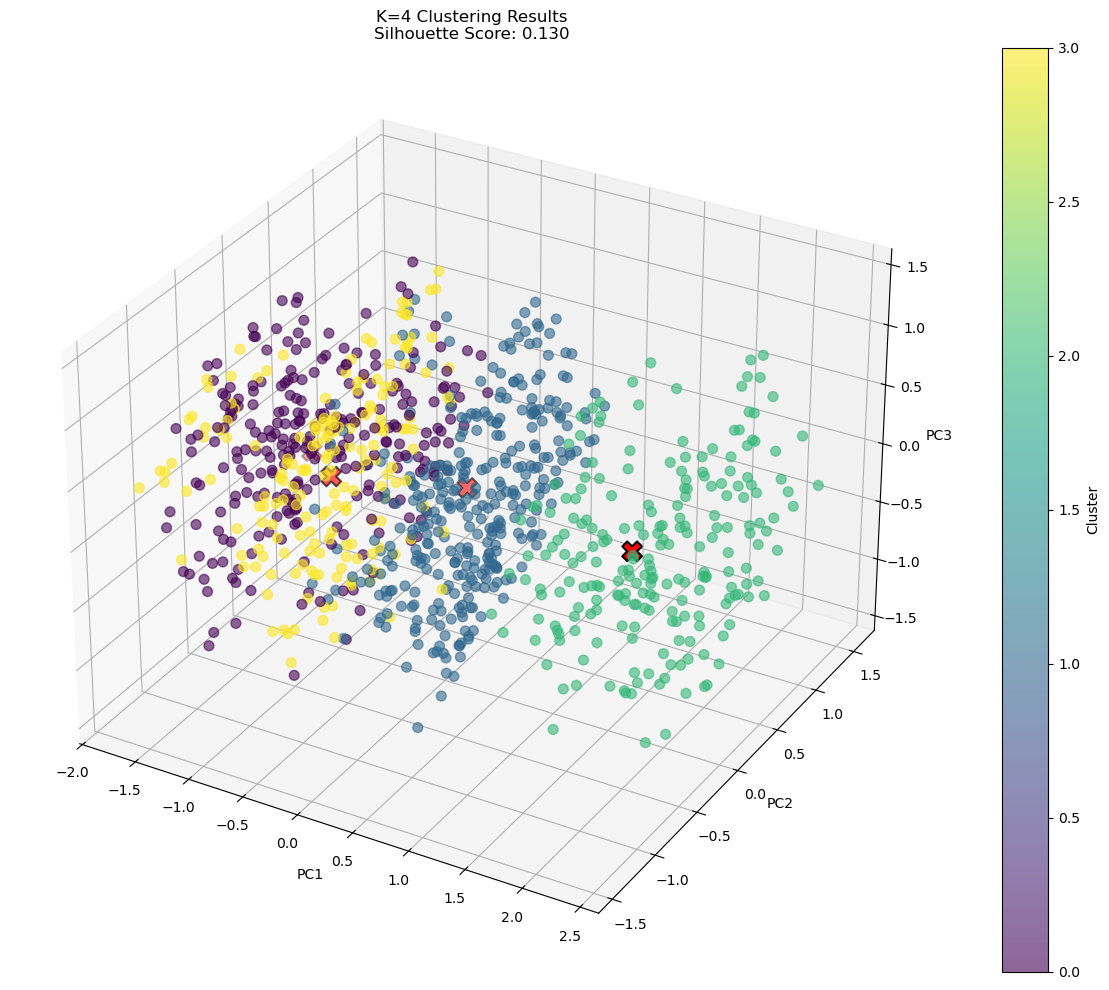

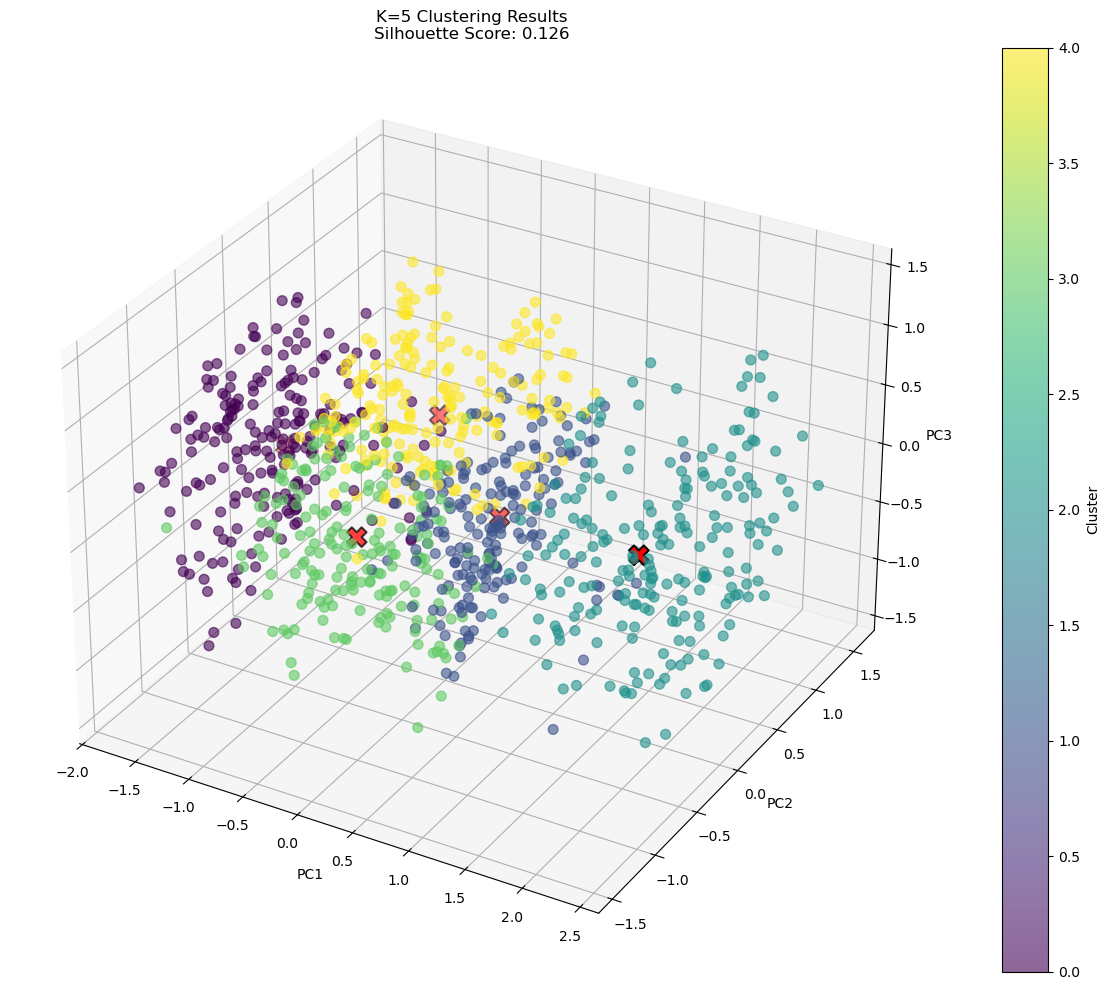

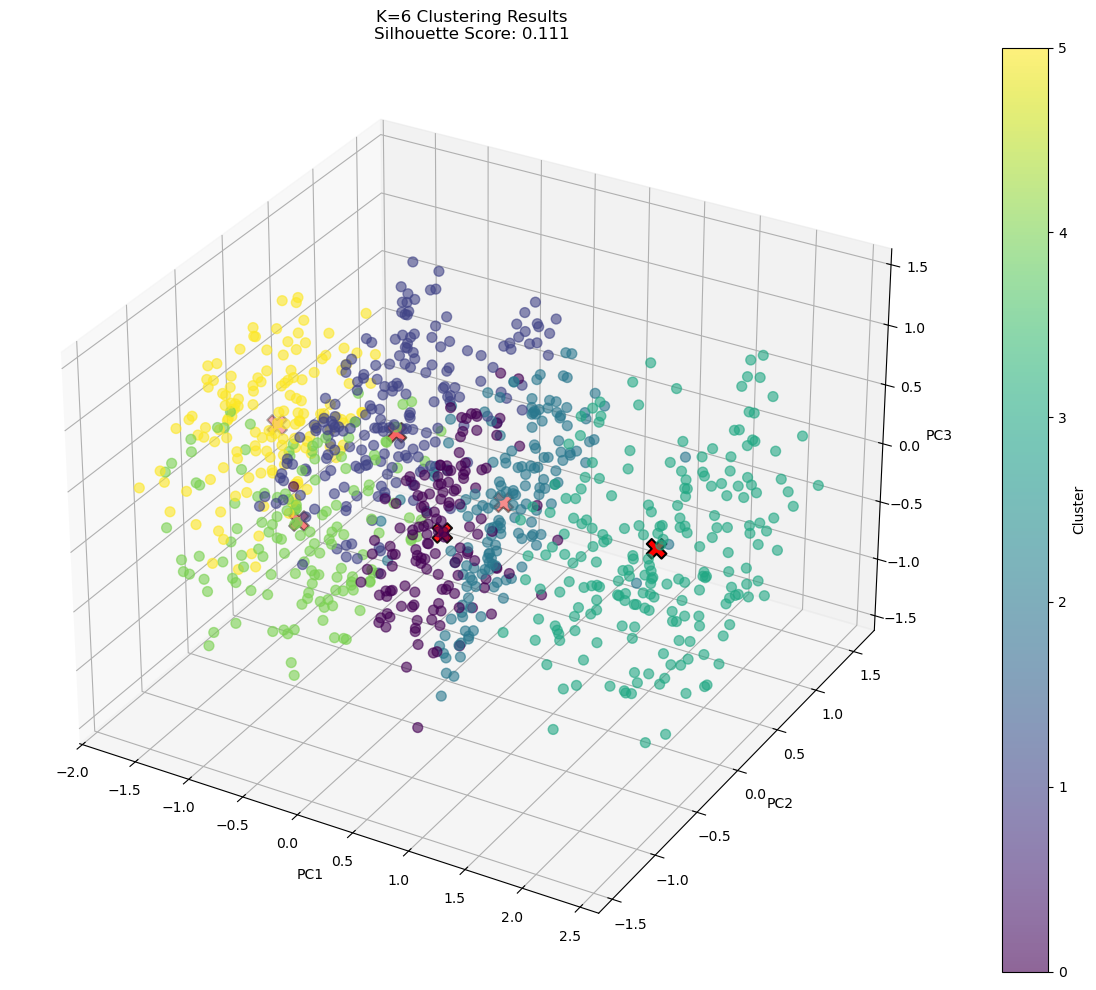

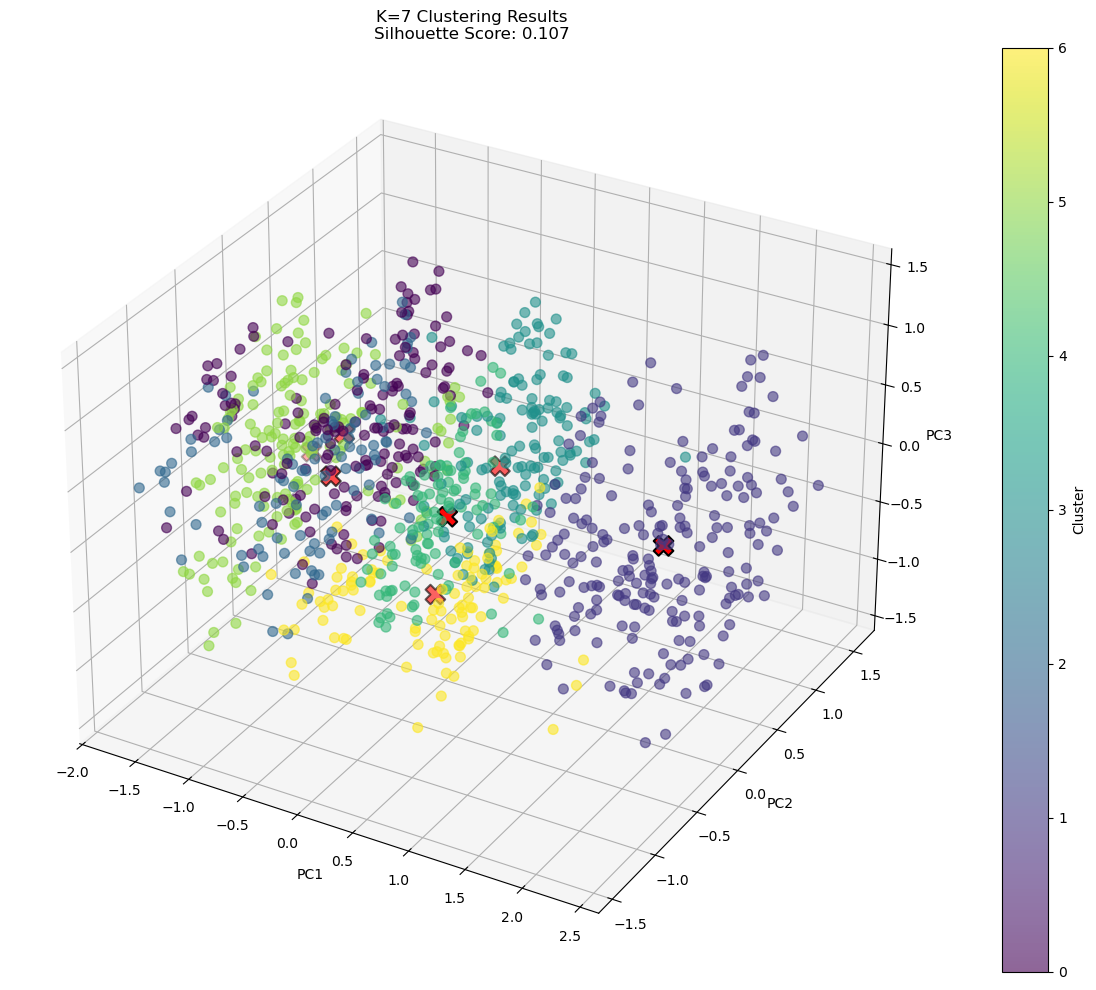

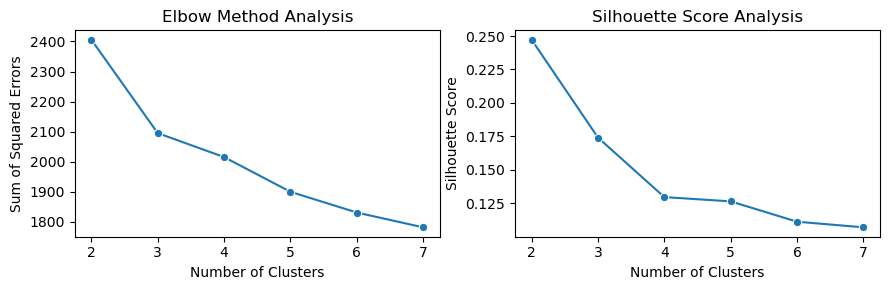

Optimal number of clusters: 2 (Silhouette Score: 0.247)


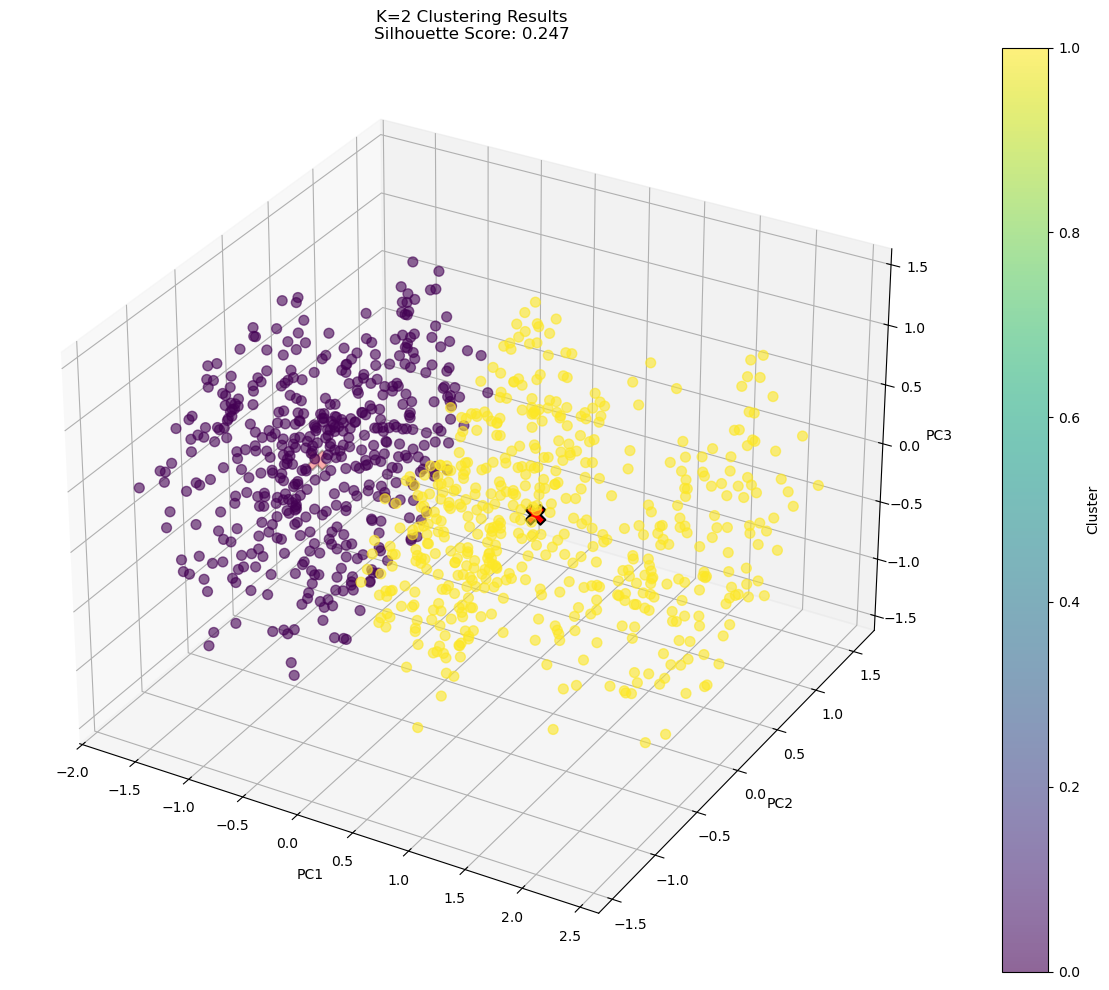

In [7]:
sse_values = []
silhouette_scores = []
results = {}

for k, job_name in training_jobs:
    try:
        # Retrieve model artifacts
        job_desc = sagemaker_client.describe_training_job(TrainingJobName=job_name)
        model_path = job_desc['ModelArtifacts']['S3ModelArtifacts']
        
        # Download and extract model
        local_path = f'/tmp/model-k-{k}.tar.gz'
        boto3.client('s3').download_file(bucket, model_path.replace(f's3://{bucket}/', ''), local_path)
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
            
        # Load model parameters
        model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        centroids = model_params[0].asnumpy()
        
        # Calculate cluster assignments
        distances = np.linalg.norm(data_np[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Calculate metrics
        sse = np.sum((data_np - centroids[labels])**2)
        sil_score = silhouette_score(data_np, labels)
        
        sse_values.append(sse)
        silhouette_scores.append(sil_score)
        
        # Plot results for each k
        results[k] = (labels, centroids)
        plot_cluster_results(data_np, labels, centroids, f'K={k} Clustering Results')
        
    except Exception as e:
        print(f'Error processing K={k}: {str(e)}')

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sns.lineplot(x=k_values, y=sse_values, marker='o', ax=ax1)
ax1.set_title('Elbow Method Analysis')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of Squared Errors')

sns.lineplot(x=k_values, y=silhouette_scores, marker='o', ax=ax2)
ax2.set_title('Silhouette Score Analysis')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# Select optimal K
best_k = k_values[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters: {best_k} (Silhouette Score: {max(silhouette_scores):.3f})')

plot_cluster_results(data_np, results[best_k][0], results[best_k][1], f'K={best_k} Clustering Results')